# Media Group test task

Блок 1. ЛОГИКА

1.	За июль стоимость платья возросла на 40%, а за август на 10% к июлю. На сколько % выросла цена за 2 месяца?

  Ответ: **54%**

2.	Аня может съесть 1кг яблок за неделю, а с подругой 1кг яблок хватит на 6 дней. За сколько дней съесть 1кг яблок подруга Ани?

  Ответ: **42 дня**
 


Блок 2. ТЕХНИЧЕСКИЕ ВОПРОСЫ

1.	Как оценить качество регрессионной модели (критерии, тесты, показатели)?

  Ответ: **R-квадрат, среднеквадратическая ошибка(MSE) или корень из MSE(RMSE), средняя абсолютная ошибка(MAE); критерий Дарбина-Уотсона, F-тест**

2.	Можем ли использовать модель, если в ней присутствует автокорреляция? Почему?

  Ответ: **Использование такой модели нежелательно: из-за автокорреляции данные начинают влиять друг на друга, в итоге оценки модели искажаются, некоторые статистики могут быть завышены. Проверить наличие автокорреляции можно при помощи корреляционной матрицы в виде heatmap для наглядности.**

3.	Как действовать, если необходимый для моделирования ряд данных содержит 1) пропущенные значения, 2) выбросы? 

  Ответ: **Пропущенные значения можно заполнить (pandas: `df.fillna()`) или убрать строки с ними (pandas: `df.dropna()`); выбросы можно оценить при помощи `scipy.stats.zscore` и убрать строки с ними.**

Блок 3. КЕЙС

Начнём с импорта необходимых библиотек.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

Создаю по датафрейму для каждого листа в экселе, выбираю интересующий меня бренд и суммирую продажи за каждую неделю для последующего анализа.

In [2]:
df_cat = pd.read_excel('dataset.xlsx', sheet_name="category data")
df_gen = pd.read_excel('dataset.xlsx', sheet_name="general data")
df_cat = df_cat[df_cat['Brand'] == "DEEP RELIEF"]
weekly_sales_indexed = df_cat[['Index', 'Sales_packs']].groupby('Index').sum().reset_index()
weekly_sales = weekly_sales_indexed['Sales_packs']
print(weekly_sales.head())

0    10823.65
1    11410.88
2    11584.99
3    11874.97
4    11648.06
Name: Sales_packs, dtype: float64


Строю график данных при помощи `lineplot`.

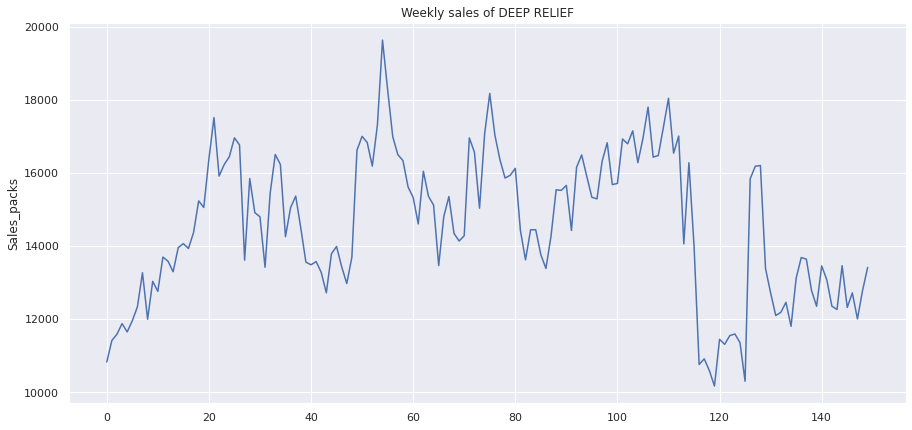

In [3]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.lineplot(data=weekly_sales)
plt.title('Weekly sales of DEEP RELIEF');

При помощи скользящей средней `DataFrame.rolling(window).mean()` ищу тренды и закономерности.

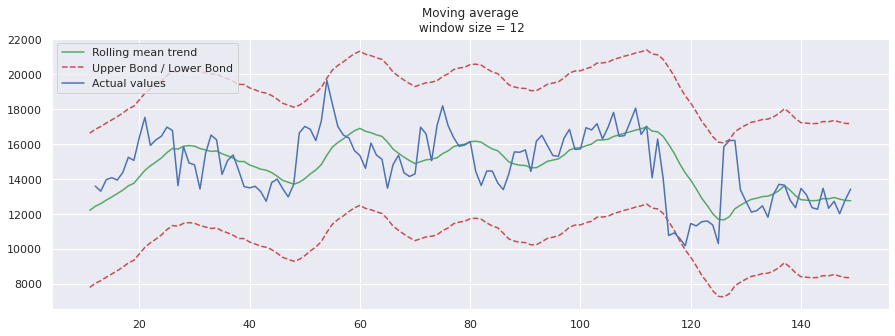

In [4]:
def plot_moving_average(series, window, scale=1.96):
    """
        series - dataframe with time series
        window - rolling window size
        plot_intervals - show confidence intervals
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True);


plot_moving_average(weekly_sales, 12)

Теперь я построю и обучу модель на основе экспоненциального сглаживания Хольта-Винтерса, а затем попробую предсказать при её помощи продажи крайних десяти недель. 

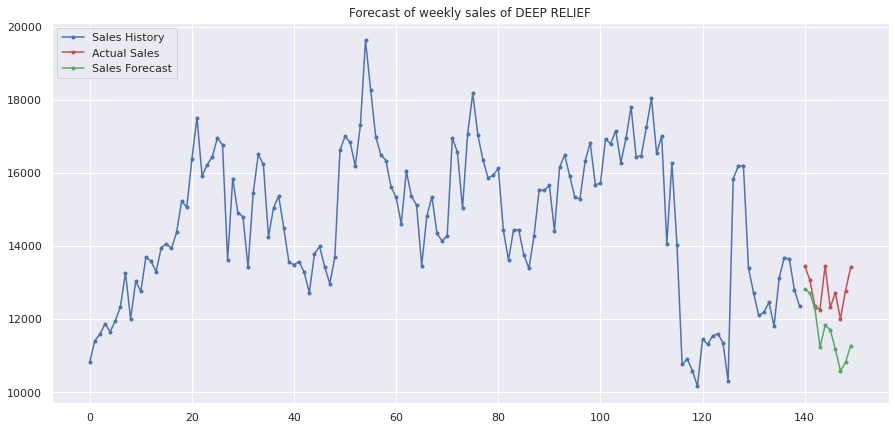

In [5]:
df_train = weekly_sales.iloc[:-10]
df_test = weekly_sales.iloc[-10:]

model = ExponentialSmoothing(df_train, seasonal_periods=52, trend='add', seasonal='mul')
fitted = model.fit()

sales_forecast = fitted.forecast(steps=10)

sns.set(rc={'figure.figsize': (15, 7)})
plt.title('Forecast of weekly sales of DEEP RELIEF')
plt.plot(df_train.index, df_train, 'b.-', label='Sales History')
plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
plt.plot(df_test.index, sales_forecast, 'g.-', label='Sales Forecast')
plt.legend(loc="upper left")
plt.grid(True);

Попробуем сделать более точный прогноз используя больше данных.

Для начала уберём из `df_cat` пустые колонки.

In [6]:
df_cat.dropna(how='all', axis=1, inplace=True)
print(df_cat.columns)

Index(['Year', 'Week', 'Index', 'Product', 'Sales_packs', 'Sales_UAH',
       'Penetration', 'Pricer_per_pack', 'Brand', 'Aw_MMI',
       'Internet_insertions', 'TV_TRP', 'SOV, %', 'TRP_category'],
      dtype='object')


Далее нужно определиться как адаптировать наши данные для недельных продаж.

У нас есть три продукта бренда DEEP RELIEF, они отличаются своей дозировкой. Я посмотрел на датасет и увидел, что значения `['Aw_MMI', 'Internet_insertions', 'TV_TRP', 'SOV, %', 'TRP_category']` равны для каждого из продуктов еженедельно.
`'Penetration'` я внёс как среднее арифметическое трёх продуктов, а `'Pricer_per_pack'` - как среднее арифметическое цены за один грамм лекарства.

Также я интерполировал пустые ячейки `'Aw_MMI'`.

In [7]:
df_cat_prod_0 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 50 g"]
df_cat_prod_1 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 100 g"]
df_cat_prod_2 = df_cat[df_cat['Product'] == "DEEP RELIEF, Delta Medical LLC (Ukraine, Vishneve), gel tube 15 g"]

df_cat_prod_0.reset_index(inplace=True)
df_cat_prod_1.reset_index(inplace=True)
df_cat_prod_2.reset_index(inplace=True)

df_cat_prep = df_cat_prod_0.interpolate()
df_cat_prep.fillna(method="bfill", inplace=True)
df_cat_prep.reset_index(inplace=True)
df_cat_prep = df_cat_prep[['Aw_MMI', 'Internet_insertions', 'TV_TRP', 'SOV, %', 'TRP_category']]
df_cat_prep["Sales_packs"] = weekly_sales

df_pen = pd.DataFrame()
df_pen["0"] = df_cat_prod_0["Penetration"]
df_pen["1"] = df_cat_prod_1["Penetration"]
df_pen["2"] = df_cat_prod_2["Penetration"]
df_cat_prep["Penetration"] = df_pen.mean(axis=1)
df_cat_prep["Penetration"].fillna(method="ffill", inplace=True)

df_cat_prep["Pricer_per_pack"] = df_cat_prod_0["Pricer_per_pack"].div(150) +\
                                 df_cat_prod_1["Pricer_per_pack"].div(300) +\
                                 df_cat_prod_2["Pricer_per_pack"].div(45)


Ещё я добавил сезонную и трендовую компоненты `weekly_sales`.

In [8]:
decomposition = sm.tsa.seasonal_decompose(weekly_sales, model='multiplicative', freq=52)

df_cat_prep["Trend"]  = decomposition.trend
df_cat_prep["Seasonal"]  = decomposition.seasonal

df_cat_prep["Trend"].fillna(method="bfill", inplace=True)
df_cat_prep["Trend"].fillna(method="ffill", inplace=True)

Проверим `df_cat_prep` на наличие автокорреляций.

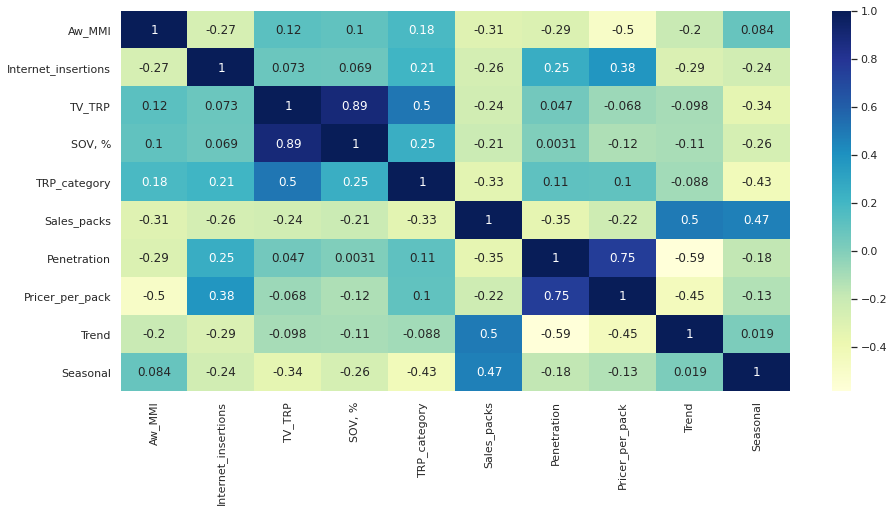

In [9]:
corr = df_cat_prep.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="YlGnBu");

Уберём из датасета 'TV_TRP'.

In [10]:
df_cat_prep.drop(columns=["TV_TRP"], inplace=True)

Далее я нормализировал данные...

In [11]:
Y = df_cat_prep["Sales_packs"]
X = df_cat_prep.drop(columns=["Sales_packs"])

In [12]:
min_max_scaler = MinMaxScaler().fit_transform(X)
X_norm = pd.DataFrame(min_max_scaler, columns=X.columns)

...и построил линейную регрессию.

In [13]:
model = sm.OLS(Y.values.reshape(-1, 1), X_norm)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              655.4
Date:                Mon, 19 Jul 2021   Prob (F-statistic):                   4.75e-108
Time:                        12:16:48   Log-Likelihood:                         -1379.4
No. Observations:                 150   AIC:                                      2775.
Df Residuals:                     142   BIC:                                      2799.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Делаю предикшн по всему датасету.

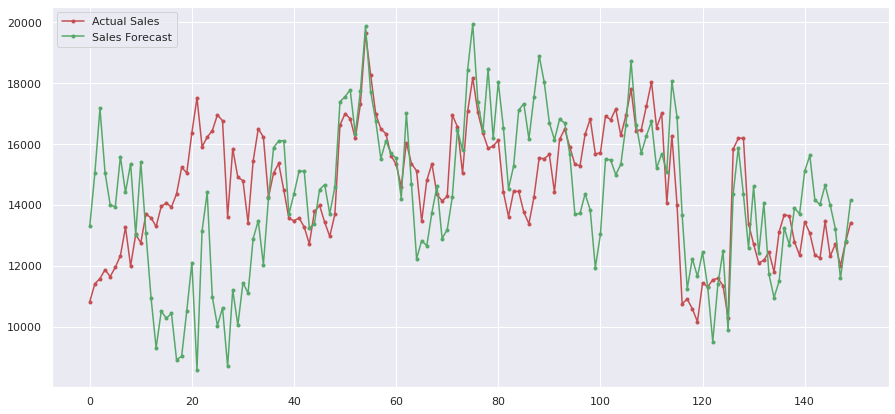

In [14]:
Y_pred = results.predict(X_norm)
plt.plot(Y.index, Y, 'r.-', label='Actual Sales')
plt.plot(Y.index, Y_pred, 'g.-', label='Sales Forecast')
plt.legend(loc="upper left");

Теперь я сделаю INNER JOIN для *category data* и *general data* чтобы посмотреть какие факторы влияют на продажи.

В *general data* отсутствуют некоторые данные, поэтому я заполняю их при помощи `interpolate()`.


In [15]:
df_gen.interpolate(inplace=True)
df_gen.fillna(method="bfill", inplace=True)
print(df_gen.head())

   Year  Month  Week  ...  Temperature  COVID info-noise  google_requests_for brand
0  2018      1     1  ...        -2.40               0.0                        9.5
1  2018      1     2  ...        -2.40               0.0                       11.0
2  2018      1     3  ...        -2.40               0.0                       13.5
3  2018      1     4  ...        -2.75               0.0                       14.5
4  2018      2     5  ...        -3.10               0.0                       13.5

[5 rows x 11 columns]


In [16]:
df = pd.merge(df_gen, weekly_sales_indexed, how='inner', on='Index')

df["Trend"]  = decomposition.trend
df["Seasonal"]  = decomposition.seasonal

df["Trend"].fillna(method="bfill", inplace=True)
df["Trend"].fillna(method="ffill", inplace=True)

print(df.columns)

Index(['Year', 'Month', 'Week', 'Index', 'IPN', 'Cons_Inflation', 'Real wage',
       'UAH_to_USD', 'Temperature', 'COVID info-noise',
       'google_requests_for brand', 'Sales_packs', 'Trend', 'Seasonal'],
      dtype='object')


Нормализуем данные.

In [17]:
x = df[['IPN', 'Cons_Inflation', 'Real wage', 'UAH_to_USD', 'Temperature', 'COVID info-noise',
        'google_requests_for brand', 'Trend', 'Seasonal']]
y = df['Sales_packs']

In [18]:
min_max_scaler = MinMaxScaler().fit_transform(x)
x_norm = pd.DataFrame(min_max_scaler, columns=x.columns)

Теперь можно построить линейную регрессию.

In [19]:
model = sm.OLS(y.values.reshape(-1, 1), x_norm)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              1045.
Date:                Mon, 19 Jul 2021   Prob (F-statistic):                   5.68e-123
Time:                        12:16:48   Log-Likelihood:                         -1317.3
No. Observations:                 148   AIC:                                      2653.
Df Residuals:                     139   BIC:                                      2680.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Делаю предикшн всего датасета.

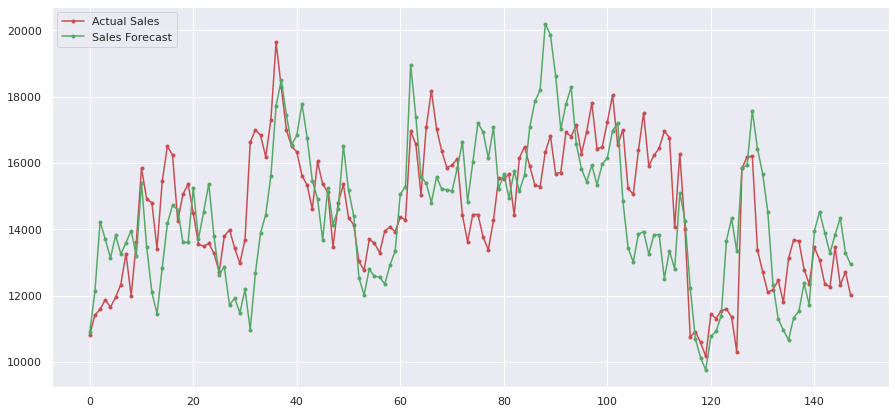

In [20]:
y_pred = results.predict(x_norm)
plt.plot(y.index, y, 'r.-', label='Actual Sales')
plt.plot(y.index, y_pred, 'g.-', label='Sales Forecast')
plt.legend(loc="upper left");

Посмотрим какие факторы имели наибольшее влияние.

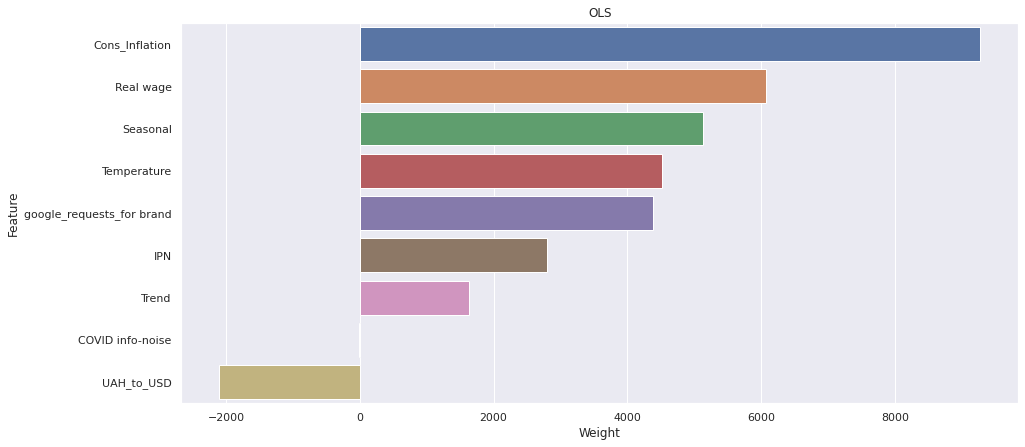

In [21]:
ols_fea = pd.DataFrame(results.params)
ols_fea["Feature"] = list(x)
ols_fea.sort_values(by=0, ascending=False, inplace=True)
p = sns.barplot(0, "Feature", data=ols_fea, orient='h')
p.set_xlabel("Weight")
p.set_title('OLS');

Как видим, больше всего на продажи влияют инфляция и средняя з/п. Рост курса доллара имеет негативный эффект, что весьма ожидаемо.